# Making and training a U-net for seismic phase detection


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
# from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import pandas as pd
import h5py

## Build the U-net

In [2]:
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

In [3]:
model = UNet1D()

In [4]:
summary(model, input_size=(1, 3, 3000))

Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 3, 3000]              --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 3000]             --
│    │    └─Sequential: 3-1              [1, 16, 3000]             944
│    └─ConvBlock: 2-2                    [1, 32, 1500]             --
│    │    └─Sequential: 3-2              [1, 32, 1500]             4,672
│    └─ConvBlock: 2-3                    [1, 64, 750]              --
│    │    └─Sequential: 3-3              [1, 64, 750]              18,560
│    └─ConvBlock: 2-4                    [1, 128, 375]             --
│    │    └─Sequential: 3-4              [1, 128, 375]             73,984
├─ConvBlock: 1-2                         [1, 256, 187]             --
│    └─Sequential: 2-5                   [1, 256, 187]             --
│    │    └─Conv1d: 3-5                  [1, 256, 187]             98,560

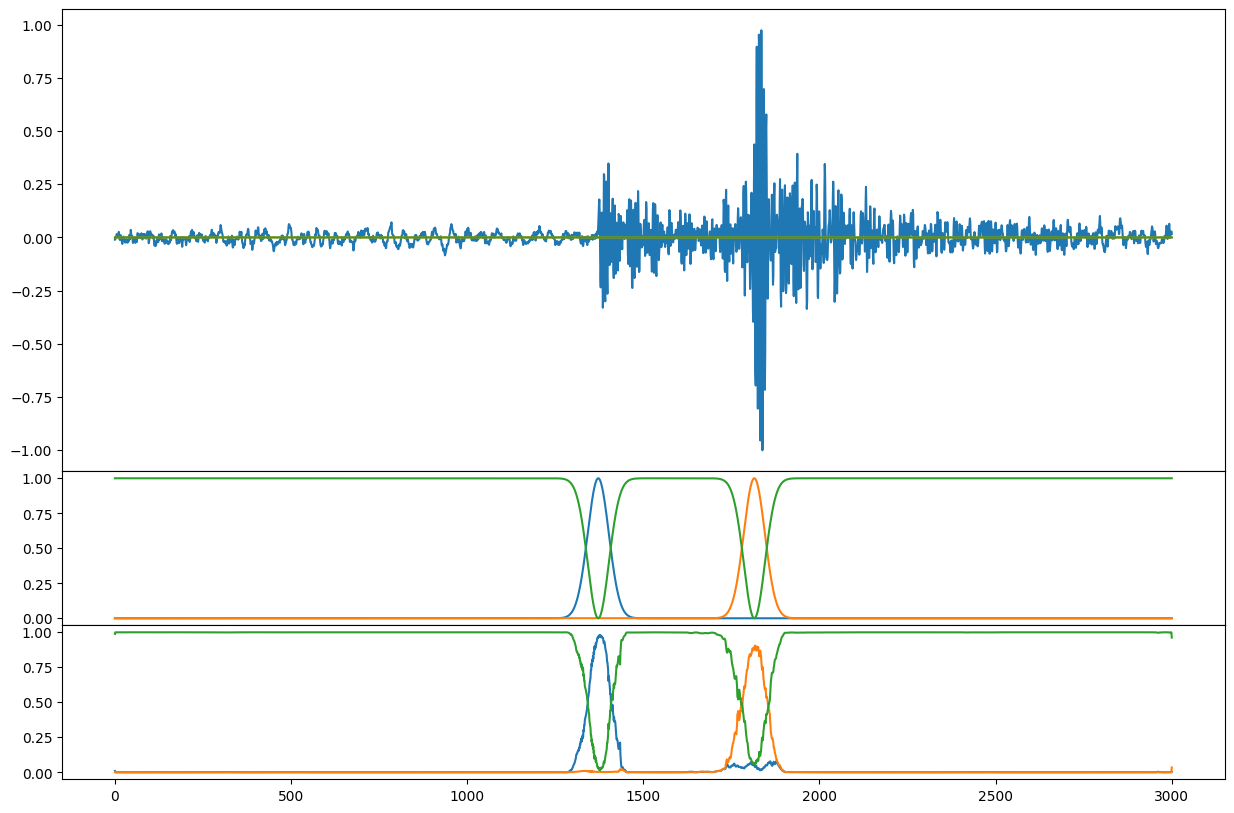

In [16]:
sample = test_generator[np.random.randint(len(test_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

In [17]:
torch.save(model.state_dict(), "model_weights.pt")
torch.save(model, "fullmodel_with_architacture.pt")

# Load model for ref

In [18]:
model = UNet1D()
model.load_state_dict(torch.load("model_weights.pt"))
model.eval()  # set to eval mode for inference

UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU